In [38]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import csv
import scipy
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import time

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
%ls drive/MyDrive/'ML Proyecto'

Dataset/  ML_Project-main/  RandomForest.ipynb


In [29]:
DATASET = '/content/drive/MyDrive/ML Proyecto/Dataset/Emotions'

In [30]:
def ensure_sample_rate(waveform, original_sample_rate, desired_sample_rate=16000):
    if original_sample_rate != desired_sample_rate:
        desired_length = int(round(float(len(waveform)) / original_sample_rate * desired_sample_rate))
        waveform = scipy.signal.resample(waveform, desired_length)
    return waveform, desired_sample_rate

In [31]:
wav_path = f'{DATASET}/Angry/03-01-05-01-01-01-01.wav'
wav_data, sample_rate = librosa.load(wav_path)
print(f'Original sample rate: {sample_rate} Hz')

# Ensure that the sample rate is set to 16 kHz and calculate the sample length in seconds.
waveform, sample_rate = ensure_sample_rate(wav_data, sample_rate)
duration = len(waveform)/sample_rate

# Show some basic information about the audio.
print(f'Model Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(waveform)}')

# Listening to the wav file.
Audio(waveform, rate=sample_rate)

Original sample rate: 22050 Hz
Model Sample rate: 16000 Hz
Total duration: 3.87s
Size of the input: 61929


In [32]:
labels = {
    'Angry': 0,
    'Happy': 1,
    'Sad': 2,
    'Fearful': 3,
    'Disgusted': 4,
    'Neutral': 5,
    'Suprised': 6
}

In [39]:
lst = []
i = -2
start_time = time.time()
for subdir, dirs, files in os.walk(DATASET):
  i=i+1
  print(subdir)
  print(i)
  for file in files:
        #Load librosa array, obtain mfcss, add them to array and then to list.
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_fft=4096, hop_length=256, n_mfcc=40).T,axis=0) 
        arr = mfccs, i
        lst.append(arr) #Here we append the MFCCs to our list.
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

/content/drive/MyDrive/ML Proyecto/Dataset/Emotions
-1
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Angry
0
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Disgusted
1
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Fearful
2
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Happy
3
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral
4
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Sad
5
/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Suprised
6
--- Data loaded. Loading time: 1332.1192512512207 seconds ---


# Analisis de Audio

In [42]:
#Add paths and get signals.

file1='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/03-02-01-01-02-02-20.wav'
signal1, sample_rate = librosa.load(file1, sr=22050)

file2='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/1007_WSI_NEU_XX.wav'
signal2, sample_rate = librosa.load(file2, sr=22050)

file3='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/n01.wav'
signal3, sample_rate = librosa.load(file3, sr=22050)

file4='/content/drive/MyDrive/ML Proyecto/Dataset/Emotions/Neutral/YAF_vote_neutral.wav'
signal4, sample_rate = librosa.load(file4, sr=22050)

emotion='Neutral'

## Grafica de las formas de Onda

Text(0.5, 1.0, 'TESS Waveform Neutral')

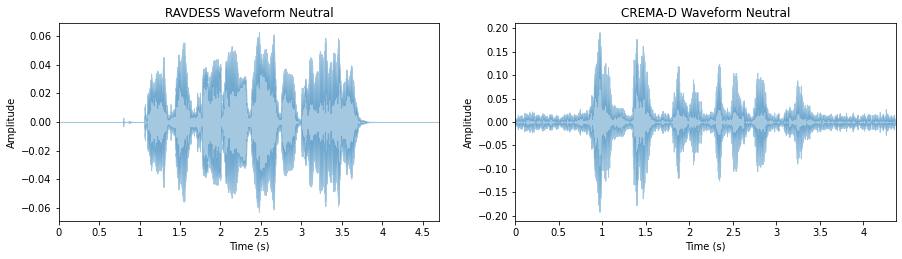

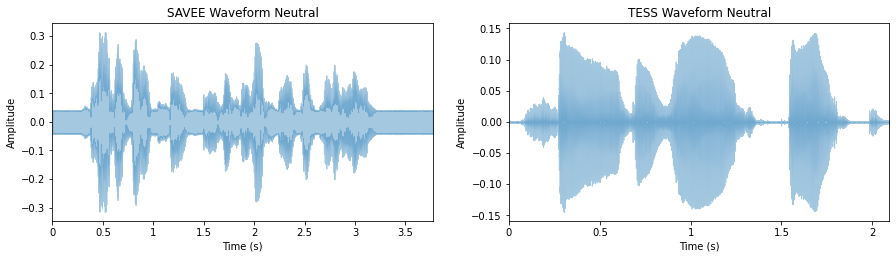

In [44]:
from librosa import display
fig = plt.figure(figsize=(15,8))
# WAVEFORM
# display waveform
plt.subplot(2, 2, 1)
librosa.display.waveplot(signal1,sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("RAVDESS Waveform "+emotion)

plt.subplot(2, 2, 2)
librosa.display.waveplot(signal2,sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("CREMA-D Waveform "+emotion)


fig = plt.figure(figsize=(15,8))
plt.subplot(2, 2, 3)
librosa.display.waveplot(signal3,sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("SAVEE Waveform "+emotion)

plt.subplot(2, 2, 4)
librosa.display.waveplot(signal4,sample_rate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("TESS Waveform "+emotion)

## Espectros y Transformada de Fourier

Text(0.5, 1.0, 'TESS Power spectrum Neutral')

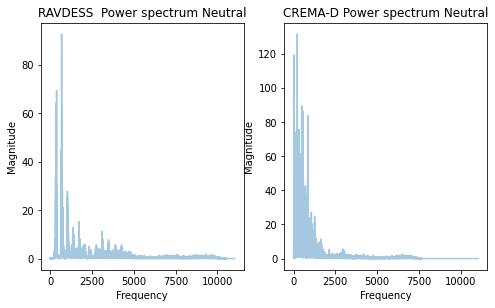

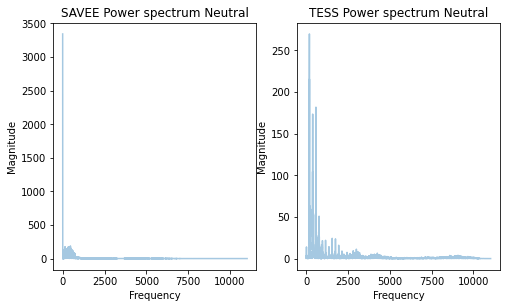

In [45]:
# FFT -> power spectrum
# perform Fourier transform
fft1 = np.fft.fft(signal1)
fft2 = np.fft.fft(signal2)
fft3 = np.fft.fft(signal3)
fft4 = np.fft.fft(signal4)

# calculate abs values on complex numbers to get magnitude
spectrum1 = np.abs(fft1)
spectrum2 = np.abs(fft2)
spectrum3 = np.abs(fft3)
spectrum4 = np.abs(fft4)

# create frequency variable
f1 = np.linspace(0, sample_rate, len(spectrum1))
f2 = np.linspace(0, sample_rate, len(spectrum2))
f3 = np.linspace(0, sample_rate, len(spectrum3))
f4 = np.linspace(0, sample_rate, len(spectrum4))

# take half of the spectrum and frequency
left_spectrum1 = spectrum1[:int(len(spectrum1)/2)]
left_f1 = f1[:int(len(spectrum1)/2)]
# take half of the spectrum and frequency
left_spectrum2 = spectrum2[:int(len(spectrum2)/2)]
left_f2 = f2[:int(len(spectrum2)/2)]
# take half of the spectrum and frequency
left_spectrum3 = spectrum3[:int(len(spectrum3)/2)]
left_f3 = f3[:int(len(spectrum3)/2)]
# take half of the spectrum and frequency
left_spectrum4 = spectrum4[:int(len(spectrum4)/2)]
left_f4 = f4[:int(len(spectrum4)/2)]

fig = plt.figure(figsize=(8,10))
plt.subplot(2, 2, 1)
# plot spectrum
plt.plot(left_f1, left_spectrum1, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("RAVDESS  Power spectrum "+emotion)

plt.subplot(2, 2,2)
# plot spectrum
plt.plot(left_f2, left_spectrum2, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("CREMA-D Power spectrum "+emotion)


fig = plt.figure(figsize=(8,10))

plt.subplot(2, 2, 3)
plt.plot(left_f3, left_spectrum3, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("SAVEE Power spectrum "+emotion)

plt.subplot(2, 2, 4)
plt.plot(left_f4, left_spectrum4, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("TESS Power spectrum "+emotion)

## Espectrogramas


STFT hop length duration is: 0.011609977324263039s
STFT window duration is: 0.18575963718820862s


Text(0.5, 1.0, 'TESS Spectrogram Neutral')

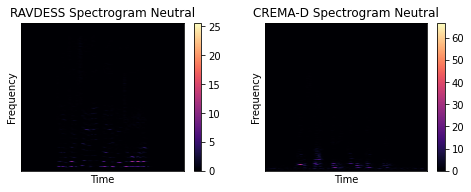

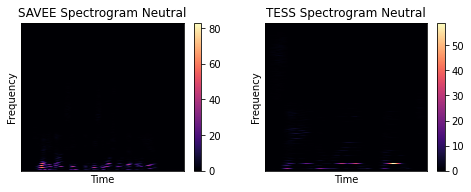

In [46]:
# STFT -> spectrogram
hop_length =256 # in num. of samples
n_fft = 4096 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft1 = librosa.stft(signal1, n_fft=n_fft, hop_length=hop_length)
stft2 = librosa.stft(signal2, n_fft=n_fft, hop_length=hop_length)
stft3 = librosa.stft(signal3, n_fft=n_fft, hop_length=hop_length)
stft4 = librosa.stft(signal4, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram1 = np.abs(stft1)
spectrogram2 = np.abs(stft2)
spectrogram3 = np.abs(stft3)
spectrogram4 = np.abs(stft4)


# display spectrogram


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
librosa.display.specshow(spectrogram1, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("RAVDESS Spectrogram "+emotion)

plt.subplot(2, 2,2)
librosa.display.specshow(spectrogram2, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("CREMA-D Spectrogram "+emotion)


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 3)
librosa.display.specshow(spectrogram3, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("SAVEE Spectrogram "+emotion)

plt.subplot(2, 2, 4)
librosa.display.specshow(spectrogram4, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("TESS Spectrogram "+emotion)

In [47]:
#This doesn't show much does it. Lets try to apply logarhithm to cast amplitude to decibels!
log_spectrogram1 = librosa.amplitude_to_db(spectrogram1)
log_spectrogram2 = librosa.amplitude_to_db(spectrogram2)
log_spectrogram3 = librosa.amplitude_to_db(spectrogram3)
log_spectrogram4 = librosa.amplitude_to_db(spectrogram4)

Text(0.5, 1.0, 'TESS Spectogramm (dB) Neutral')

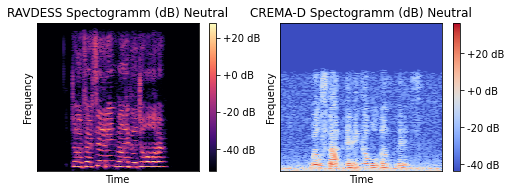

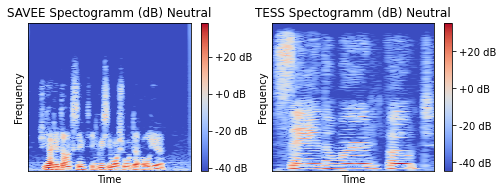

In [48]:
fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
librosa.display.specshow(log_spectrogram1, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("RAVDESS Spectogramm (dB) "+emotion)

plt.subplot(2, 2,2)
librosa.display.specshow(log_spectrogram2, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("CREMA-D Spectogramm (dB) "+emotion)


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 3)
librosa.display.specshow(log_spectrogram3, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("SAVEE Spectogramm (dB) "+emotion)

plt.subplot(2, 2, 4)
librosa.display.specshow(log_spectrogram4, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("TESS Spectogramm (dB) "+emotion)

Text(0.5, 1.0, 'TESS MFCCs Neutral')

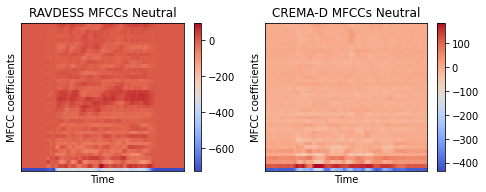

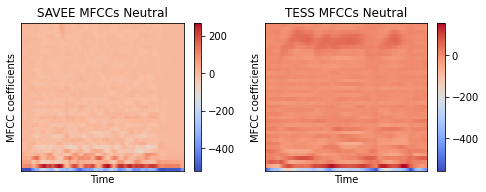

In [49]:
# MFCCs
# extract 13 MFCCs
MFCCs1 = librosa.feature.mfcc(signal1, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
MFCCs2 = librosa.feature.mfcc(signal2, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
MFCCs3 = librosa.feature.mfcc(signal3, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
MFCCs4 = librosa.feature.mfcc(signal4, sample_rate, n_fft=4096, hop_length=256, n_mfcc=40)
# display MFCCs
hop_length=256 
fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
librosa.display.specshow(MFCCs1, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("RAVDESS MFCCs "+emotion)

plt.subplot(2, 2,2)
librosa.display.specshow(MFCCs2, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("CREMA-D MFCCs "+emotion)


fig = plt.figure(figsize=(8,6))
plt.subplot(2, 2, 3)
librosa.display.specshow(MFCCs3, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("SAVEE MFCCs "+emotion)


plt.subplot(2, 2, 4)
librosa.display.specshow(MFCCs4, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("TESS MFCCs "+emotion)                             

https://en.wikipedia.org/wiki/Mel-frequency_cepstrum#:~:text=Mel%2Dfrequency%20cepstral%20coefficients%20(MFCCs,%2Da%2Dspectrum%22

# Clasificador

In [59]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [51]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)
import numpy as np
X = np.asarray(X)
y = np.asarray(y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#As always we need to expand the dimensions, so we can input the data to NN.
x_trainn = np.expand_dims(X_train, axis=2) 
x_testnn = np.expand_dims(X_test, axis=2)

In [86]:
X.shape

(12798, 40)

In [89]:
X_train.shape, X_train.shape

(11518, 40)

In [52]:
model = keras.Sequential([

        # input layer
        keras.layers.Flatten(input_shape=(40, 1)),

        # 1st dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.1)),
        keras.layers.Dropout(0.5),

        # 2nd dense layer
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),

        # 3rd dense layer
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),

        # output layer
        keras.layers.Dense(10, activation='softmax')
    ])

    # compile model
optimiser = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [54]:
history = model.fit(x_trainn, y_train, batch_size=64, epochs=2000, validation_data=(x_testnn, y_test))

Epoch 1/2000
180/180 [==============================] - 2s 13ms/step - loss: 13.7888 - accuracy: 0.1466 - val_loss: 8.3795 - val_accuracy: 0.2039
Epoch 2/2000
180/180 [==============================] - 1s 7ms/step - loss: 13.4523 - accuracy: 0.1448 - val_loss: 8.2667 - val_accuracy: 0.1969
Epoch 3/2000
180/180 [==============================] - 1s 7ms/step - loss: 13.0704 - accuracy: 0.1528 - val_loss: 8.1594 - val_accuracy: 0.1953
Epoch 4/2000
180/180 [==============================] - 1s 7ms/step - loss: 12.5128 - accuracy: 0.1543 - val_loss: 8.0516 - val_accuracy: 0.2023
Epoch 5/2000
180/180 [==============================] - 1s 7ms/step - loss: 12.1734 - accuracy: 0.1528 - val_loss: 7.9452 - val_accuracy: 0.2008
Epoch 6/2000
180/180 [==============================] - 1s 7ms/step - loss: 11.8419 - accuracy: 0.1607 - val_loss: 7.8343 - val_accuracy: 0.2000
Epoch 7/2000
180/180 [==============================] - 1s 7ms/step - loss: 11.5766 - accuracy: 0.1509 - val_loss: 7.7307 - val_a

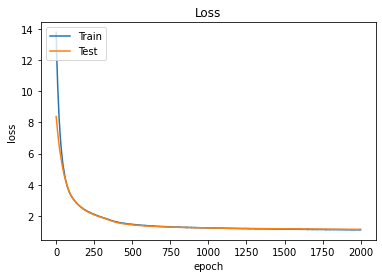

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

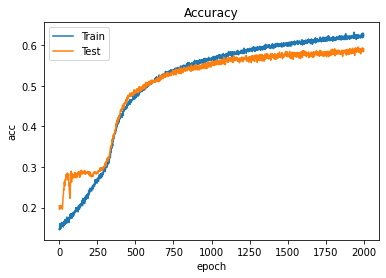

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [74]:
from sklearn.metrics import classification_report
predictions = np.argmax(model.predict(x_testnn),axis=1)
y_test = y_test.astype(int)
report = classification_report(y_test, predictions)
print(report)

40/40 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       221
           1       0.56      0.45      0.50       188
           2       0.71      0.40      0.51       216
           3       0.56      0.50      0.53       222
           4       0.48      0.59      0.53       175
           5       0.52      0.75      0.62       213
           6       0.77      0.82      0.80        45

    accuracy                           0.59      1280
   macro avg       0.61      0.61      0.60      1280
weighted avg       0.60      0.59      0.58      1280



In [69]:
y_test

array([2, 4, 0, ..., 0, 0, 3])

In [75]:
predictions

array([3, 5, 0, ..., 0, 0, 3])

## Matriz de confusion

In [76]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, predictions)

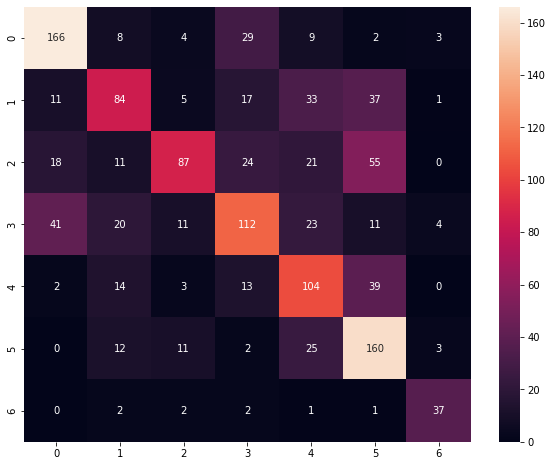

In [77]:
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(matrix, annot=True, fmt="d");

# RandomForest

In [81]:
X_train

array([[-3.4156033e+02,  2.6663641e+01, -3.0653284e+01, ...,
         1.6892561e-01,  4.0358109e+00,  7.2547379e+00],
       [-3.3087930e+02,  1.3579631e+02, -4.7434802e+00, ...,
         2.5592728e+00,  2.3520002e+00,  2.1074378e+00],
       [-3.6669025e+02,  1.5698805e+02, -2.3884762e+01, ...,
        -1.2039455e+00, -2.0160573e+00,  1.5497811e+00],
       ...,
       [-3.9411285e+02,  2.5741627e+01, -4.2582050e+01, ...,
        -6.1997813e-01,  6.8705606e+00,  9.4613314e+00],
       [-4.9882907e+02,  1.2264071e+02,  2.0352901e+01, ...,
         4.7018762e+00,  2.3769321e+00,  2.2451742e+00],
       [-3.8495770e+02,  5.6663727e+01, -3.3294476e+01, ...,
         1.0526751e+01,  1.7920729e+01,  1.5721228e+01]], dtype=float32)

In [82]:
y_train

array([2, 1, 1, ..., 2, 0, 3])

In [83]:
X_test

array([[-2.72843109e+02,  1.09470940e+02, -9.00914574e+00, ...,
         2.78106380e+00, -9.16308284e-01,  2.38820171e+00],
       [-6.14243408e+02,  4.60518837e+01, -1.77758217e+01, ...,
        -3.75168443e-01,  2.84341305e-01, -6.04360878e-01],
       [-1.85549469e+02,  1.22175667e+02, -2.18557549e+01, ...,
         3.05727291e+00,  1.52628696e+00,  9.32646275e-01],
       ...,
       [-4.12728241e+02,  7.27884598e+01, -2.61333122e+01, ...,
         3.99162459e+00,  5.78835964e+00,  9.29977798e+00],
       [-1.80264877e+02,  1.28675598e+02, -2.67074261e+01, ...,
        -7.79502451e-01, -4.18741846e+00,  1.19724882e+00],
       [-4.47840302e+02,  5.33363037e+01, -2.32631073e+01, ...,
         5.31872988e+00,  1.04501467e+01,  1.07948265e+01]], dtype=float32)

0.61640625
              precision    recall  f1-score   support

           0       0.66      0.81      0.73       221
           1       0.59      0.52      0.56       188
           2       0.65      0.41      0.50       216
           3       0.58      0.57      0.57       222
           4       0.51      0.61      0.55       175
           5       0.64      0.72      0.68       213
           6       0.89      0.87      0.88        45

    accuracy                           0.62      1280
   macro avg       0.65      0.64      0.64      1280
weighted avg       0.62      0.62      0.61      1280



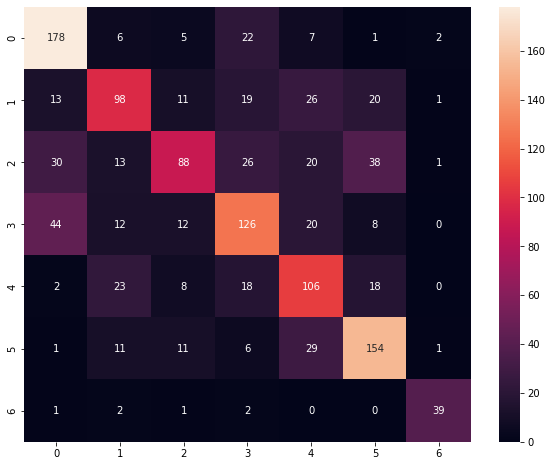

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
  
 # create regressor object 
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
classifier.fit(X_train, y_train)   

predictionRF = classifier.predict(X_test) 


print(accuracy_score(y_true=y_test,y_pred=predictionRF))
print(classification_report(y_test,predictionRF)) 
# creating a confusion matrix 
matrizr = confusion_matrix(y_test,predictionRF)
plt.figure(figsize=(10,8))
sns.heatmap(matrizr, annot=True, fmt="d");